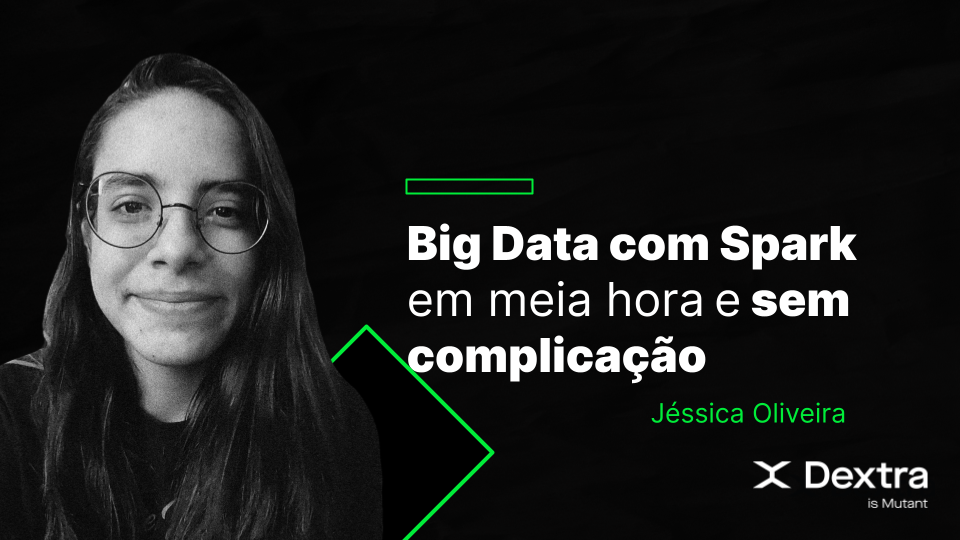

# Tecnologias de Dados - Python
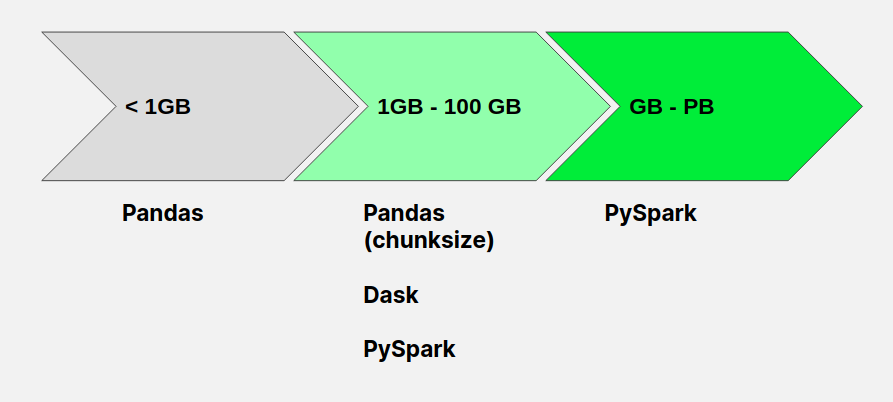

# Processamento paralelo e distribuído


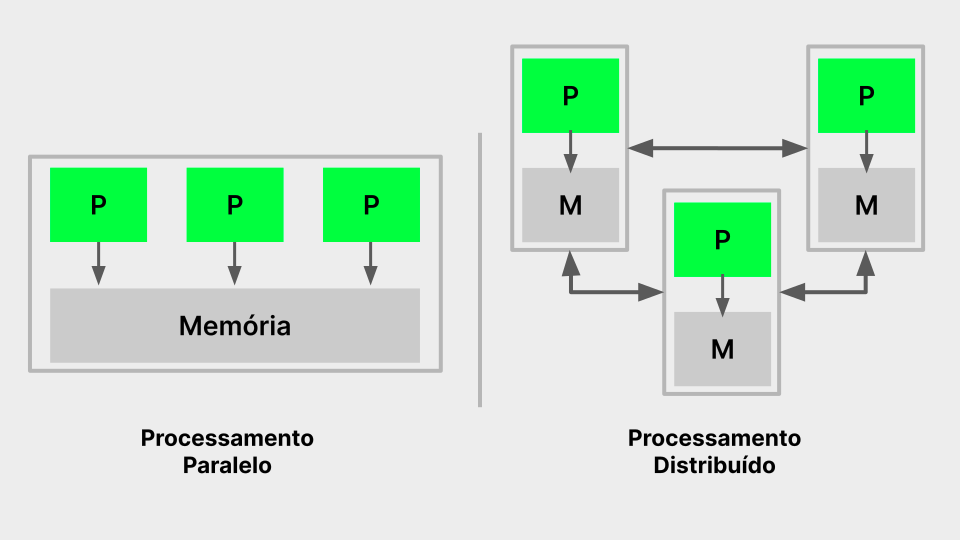

- **Processamento paralelo**: Vários processadores executam tarefas de forma simultânea. Memória pode ser compartilhada ou distribuída.

- **Processamento distribuído**: Vários computadores autônomos. Nesse tipo de processamento, a memória não é compartilhada e a comunicação entre computadores acontece por meio de mensagem. Um única aplicação é distribuída entre os computadores.

# Spark
<br/>
Motor de computação e bibliotecas para processamento paralelo de dados em cluster de computadores

Utiliza processamento distribuido para atingir performance, **particionando** os dados e alocando eles em memória distribuidos entre os nós.


> <span style="color:#089C45;  font-size:1.5em;"> Resumidamente **Spark** é uma ferramenta para **coordenar e gerenciar** execução de tarefas **paralelamente de forma distribuída** em um cluster de computadores.
</span>

## Arquitetura Spark


### Componentes
Os componentes macro de uma aplicação spark são:

- **Driver**
    - Processo no Mater Node
    - Traduz o código em Spark jobs
    - Cria o Spark Context
    - Não faz computações
- **Executors** 
    - Processo no Worker Node
    - Responsável por executar as tasks no Worker Node
- **Spark Context**
    - Criado pelo Spark Session, junto com o Spark Config
    - Utilizado para ciar RDDs
    - Envia as tasks para os executores computarem
    - Faz checagem dos executores de tempos em tempos
- **Cluster Resource Manager**
    - Controla e reserva recursos no cluster
    - Ex.: Mesos, **YARN**

<figure class="image">
  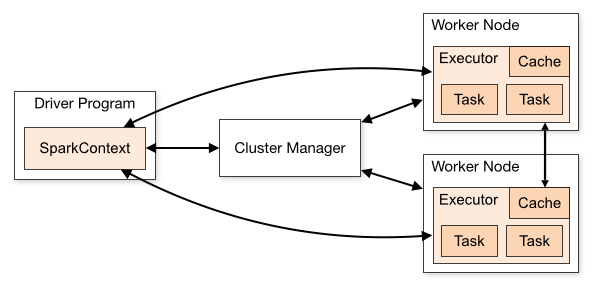
    <figcaption>Referência:https://spark.apache.org/docs/3.1.1/cluster-overview.html#components</figcaption>
</figure>

### Paticionamento


> <span style="color:#089C45;  font-size:1.2em;"> Particionamento é a principal **unidade de paralelismo** no Apache Spark.
</span>

Cada partição é enviada para workers:
 
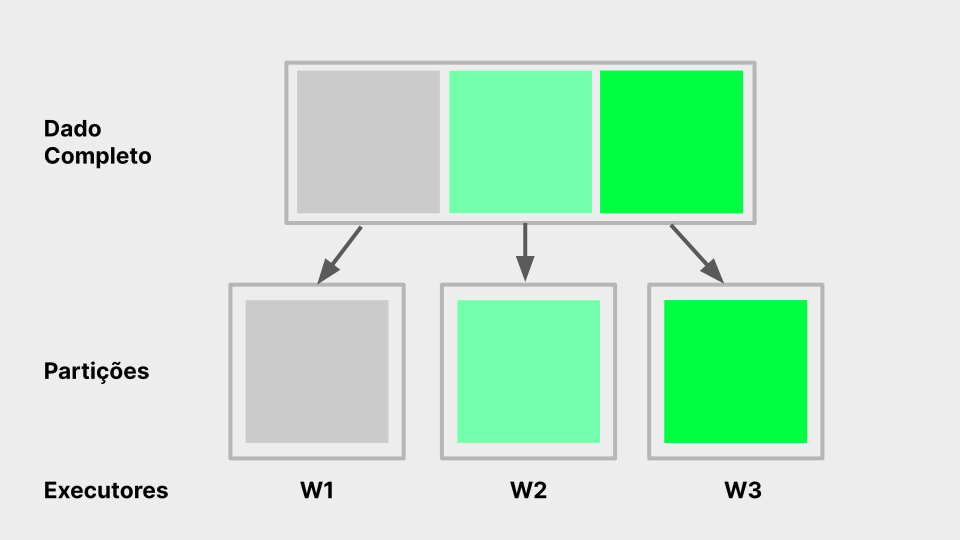

----
Referência: https://luminousmen.com/post/spark-anatomy-of-spark-application \
Comparação map reduce e spark: https://www.infoq.com/br/articles/mapreduce-vs-spark/

In [1]:
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType

In [2]:
spark = (SparkSession.builder 
        .master("local[*]") 
        .appName("workshop_spark")
        .getOrCreate())

In [3]:
spark

# Spark UI

Monitoramento da aplicação Spark, funciona através de lisseners.

Visualização detalhada da execução, com DAGs, timeline, jobs, stages e tasks. Pode ser utilizado para análise de cluster e performance.

Inicialmente _Event Timeline_ está vazio, já que não rodamos nenhum job nessa Session

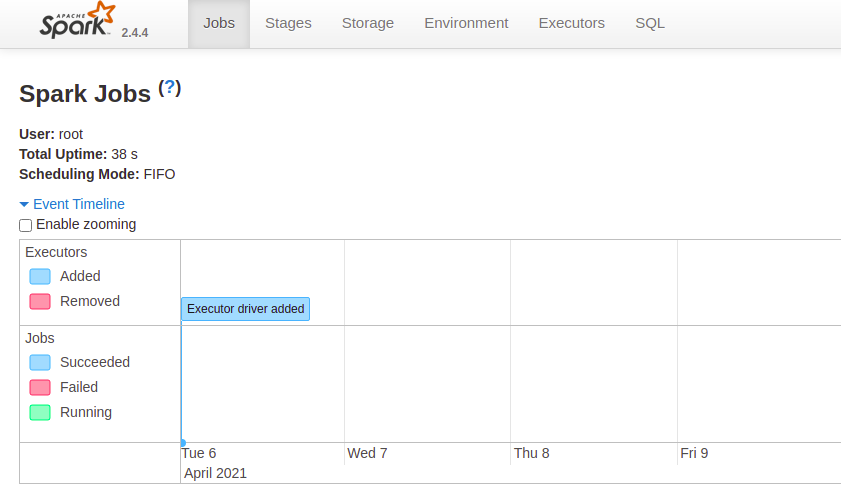

## DataFrames

Abstração do **RDDs** (Resilient Distributes Datasets), representando um coleção de dados organizados por colunas nomeadas. Conceitualmente equivalente a um tabela, em bancos de dados relacionais. 

São **imutáveis**, significando que a cada opeção é criado um novo DataFrame.

Dados abertos disponíveis na paltaforma [base dos dados mais](https://basedosdados.github.io/mais/)

In [7]:
municipios = spark.read.option("header", True).csv("../../data/municipios.csv") #Job 0
print(municipios.count())
municipios.columns

5570


['id_municipio',
 'id_municipio_6',
 'id_municipio_TSE',
 'id_municipio_RF',
 'id_municipio_BCB',
 'municipio',
 'capital_estado',
 'id_comarca',
 'id_regiao_saude',
 'regiao_saude',
 'id_regiao_imediata',
 'regiao_imediata',
 'id_regiao_intermediaria',
 'regiao_intermediaria',
 'id_microrregiao',
 'microrregiao',
 'id_mesorregiao',
 'mesorregiao',
 'id_estado',
 'estado_abrev',
 'estado',
 'regiao',
 'existia_1991',
 'existia_2000',
 'existia_2010']

In [5]:
populacao = spark.read.option("header", True).csv("../../data/populacao_municipios.csv") #Job 1
populacao.limit(3).toPandas()

,id_municipio,ano,populacao
0,1100015,1991,31981
1,1100015,1992,34768
2,1100015,1993,37036


In [6]:
nomes = spark.read.option("header", True).csv("../../data/nomes_municipios.csv") #Job 2
print(nomes.dtypes)
# lê tudo como string, por default
nomes.describe().show() #Job 4

[('id_municipio', 'string'), ('nome', 'string'), ('qtde_nascimentos_ate_2010', 'string')]
+-------+-----------------+------+-------------------------+
|summary|     id_municipio|  nome|qtde_nascimentos_ate_2010|
+-------+-----------------+------+-------------------------+
|  count|            16000| 16000|                    16000|
|   mean|   1275691.432125|  null|                237.01825|
| stddev|133120.7010056176|  null|       1061.9399168814268|
|    min|          1100015|Abdias|                      100|
|    max|          1500800|Zumira|                      998|
+-------+-----------------+------+-------------------------+



In [5]:
populacao_f = populacao.where(col("ano") == 2010) # alias do filter

municipios_f = (municipios
                .select("id_municipio", "municipio", "capital_estado", "estado", "regiao"))

nomes = nomes.withColumn("qtde_nascimentos_ate_2010", nomes["qtde_nascimentos_ate_2010"].cast(IntegerType()))

Depois dessa execução, cada leitura de arquivo inicia um job, todos concluídos com sucesso. Porém a filtragem e seleção nos dataframes não gera nenhum outro job.

Detalhe da execução da leitura dos 3 arquivos, na interface de jobs, no Spark UI:

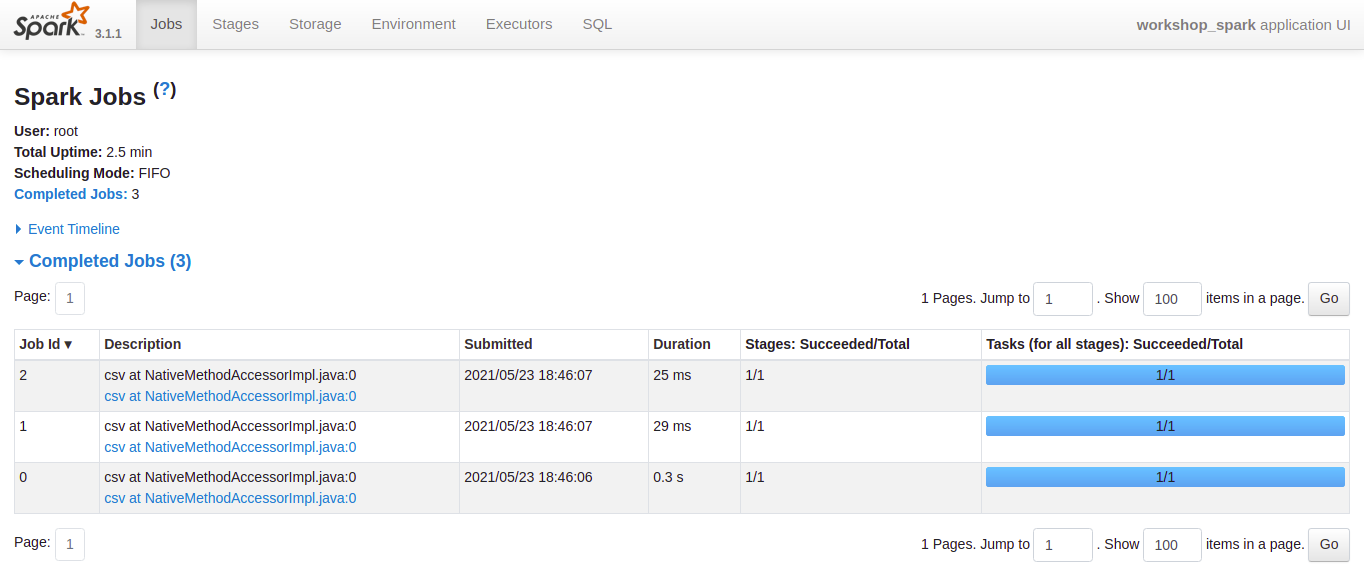


# Plano de Execução

> <span style="color:#089C45;  font-size:1.2em;"> O **plano de execução** representa o lineage dos dados e permite que Spark seja tolerante a falhas, conseguindo recuperar dados em caso de perda de nós.
</span>

Cada DataFrame possui um plano de execução associado a ele.

### Transformação
Operações de transformação criam um novo DataFrame a partir de um Dataframe base.

São chamadas _lazy_ por não ser executadas naquele momento, e são adicionadas ao plano de ação.

Tipos de transformações: \
    - **Narrow**: Não precisam de dados de outras partições. Ex.: map \
    - **Wide**: Precisam de _shuffle_ (ler dados de outras partições) e criam um outro stage. Ex.: groupby, join 

### Ação
Operações que precisam avaliar o dataframe como um todo. Ex.: show, count, write. \
Quando a ação é executada, spark executa o plano de execução.

----
Artigo "Plano de execução para leigos": https://ichi.pro/pt/planos-de-consulta-do-spark-para-leigos-122282881757510

In [6]:
populacao_f.show(2)  #Job 3

+------------+----+---------+
|id_municipio| ano|populacao|
+------------+----+---------+
|     1100015|2010|    24392|
|     1100023|2010|    90353|
+------------+----+---------+
only showing top 2 rows



Com a operação de show (ação!) o job 3 é criado
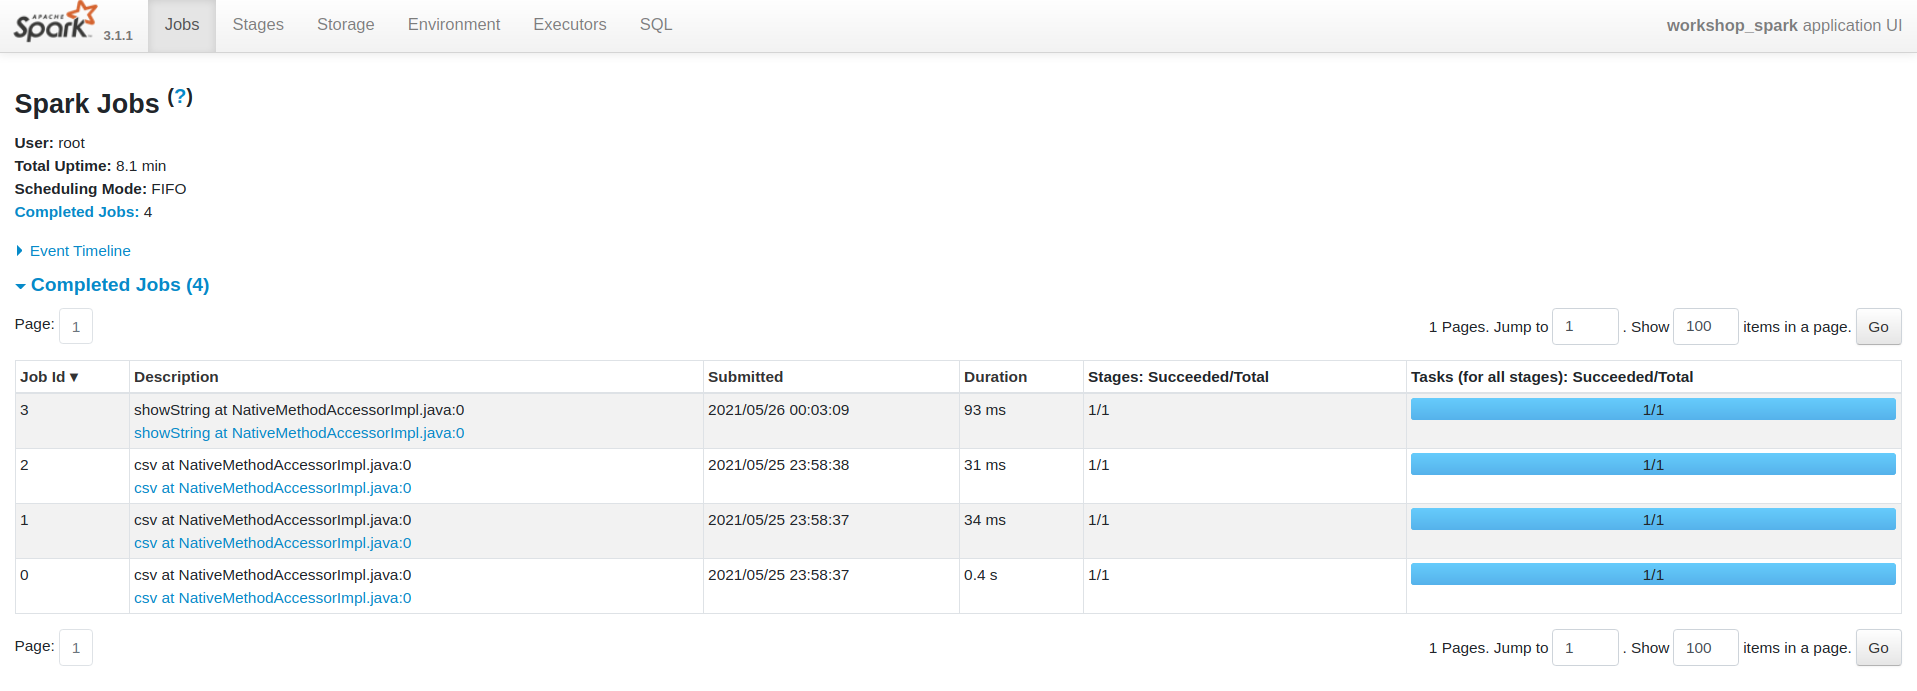

In [7]:
populacao_f.explain()

== Physical Plan ==
*(1) Filter (isnotnull(ano#83) AND (cast(ano#83 as int) = 2010))
+- FileScan csv [id_municipio#82,ano#83,populacao#84] Batched: false, DataFilters: [isnotnull(ano#83), (cast(ano#83 as int) = 2010)], Format: CSV, Location: InMemoryFileIndex[file:/opt/dna-spark/data/populacao_municipios.csv], PartitionFilters: [], PushedFilters: [IsNotNull(ano)], ReadSchema: struct<id_municipio:string,ano:string,populacao:string>




### Divisões da Aplicação

> <span style="color:#089C45;  font-size:1.2em;"> Uma vez que o plano de execução é montado, o **Driver**, no momento de execução, faz as **DAGs** e a partir disso, divide em **stages** e **tasks**.
</span>

- DAGs (Direct Acyclic Graph): Grafo que representa a **sequencia de operações aplicadas a um RDD**. Alternativo ao map reduce, mais optimizado.
- Jobs: Conjunto de Stages, **inicializados por uma ação** realizada num RDD.
- Stage: Conjunto de operações que executam em várias partições, **inicializado por uma transformação wide**.
- Tasks: Operação única aplicada a uma única **partição** de dados.

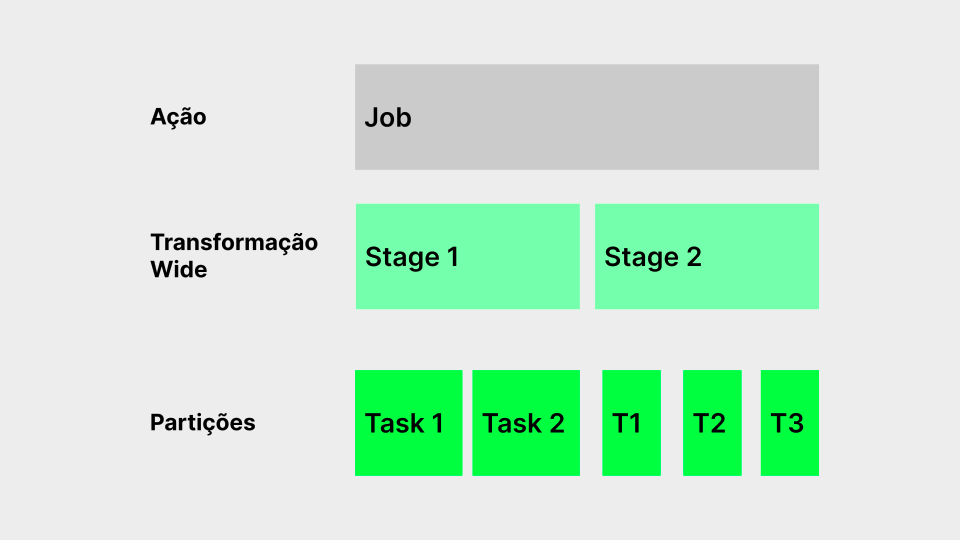

Referência: https://medium.com/expedia-group-tech/part-5-how-to-resolve-common-errors-when-switching-to-cost-efficient-apache-spark-executor-36e8d4290536
Stage em detalhes: https://towardsdatascience.com/unraveling-the-staged-execution-in-apache-spark-eff98c4cdac9

## Join

In [8]:
df = (nomes.join(municipios_f, "id_municipio", how="left")
           .join(populacao_f, "id_municipio", how="left"))

In [9]:
df.limit(5).toPandas() # Job 4, Job 5, Job 6

,id_municipio,nome,qtde_nascimentos_ate_2010,municipio,capital_estado,estado,regiao,ano,populacao
0,1100015,Ademir,46,Alta Floresta D'Oeste,0,Rondônia,Norte,2010,24392
1,1100015,Adriana,60,Alta Floresta D'Oeste,0,Rondônia,Norte,2010,24392
2,1100015,Aline,77,Alta Floresta D'Oeste,0,Rondônia,Norte,2010,24392
3,1100015,Amanda,51,Alta Floresta D'Oeste,0,Rondônia,Norte,2010,24392
4,1100015,Ana,300,Alta Floresta D'Oeste,0,Rondônia,Norte,2010,24392


## Broadcast
Broadcast é uma função _lazy_ e faz com que os valores sejam salvos em memória (se não tiver memporia suficiente, vai pro disco), para todos os executores que irão precisar desses dados.

A transimissão é feita através do `SparkContext`.

Pode ser utilizado para joins entre tabelas grandes com tabelas relativamente pequenas.

Essa estratégia de join já é utilizada automaticamente quando o tamanho de uma das tabelas fica abaixo da configuração `spark.sql.autoBroadcastJoinThreshold`.


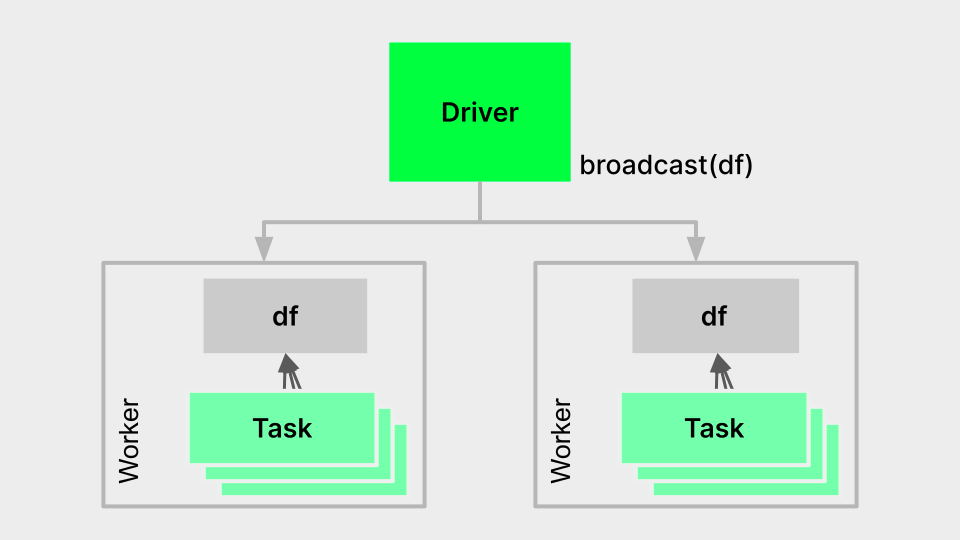

---
Exemplos: https://jaceklaskowski.gitbooks.io/mastering-spark-sql/content/spark-sql-joins-broadcast.html \
Hint: https://jaceklaskowski.gitbooks.io/mastering-spark-sql/content/spark-sql-hint-framework.html

In [10]:
df.explain()

== Physical Plan ==
*(3) Project [id_municipio#104, nome#105, qtde_nascimentos_ate_2010#115, municipio#21, capital_estado#22, estado#36, regiao#37, ano#83, populacao#84]
+- *(3) BroadcastHashJoin [id_municipio#104], [id_municipio#82], LeftOuter, BuildRight, false
   :- *(3) Project [id_municipio#104, nome#105, qtde_nascimentos_ate_2010#115, municipio#21, capital_estado#22, estado#36, regiao#37]
   :  +- *(3) BroadcastHashJoin [id_municipio#104], [id_municipio#16], LeftOuter, BuildRight, false
   :     :- *(3) Project [id_municipio#104, nome#105, cast(qtde_nascimentos_ate_2010#106 as int) AS qtde_nascimentos_ate_2010#115]
   :     :  +- FileScan csv [id_municipio#104,nome#105,qtde_nascimentos_ate_2010#106] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/opt/dna-spark/data/nomes_municipios.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<id_municipio:string,nome:string,qtde_nascimentos_ate_2010:string>
   :     +- BroadcastExchange HashedR

In [11]:
# Pode ser especificado de duas formas
df_b = nomes.join(broadcast(municipios_f), "id_municipio", how="left")
df_b = nomes.join(municipios_f.hint("broadcast"), "id_municipio", how="left")

## Particionamento na prática

Por padrão, Spark decide como fazer o particionamento dos dados, mas é possível escolher o número de partições.

A importância de particionar bem:
- Partição de menos: Não utiliza bem os recursos do cluster
- Partições de mais: Introduz overhead no gerenciamento de muitas partições

Como fazer?:

- coalesce() para diminuir o número de partições.
- repartition() para aumentar.

Caso de particionamento por chave de negócio (cuidado com data skew)
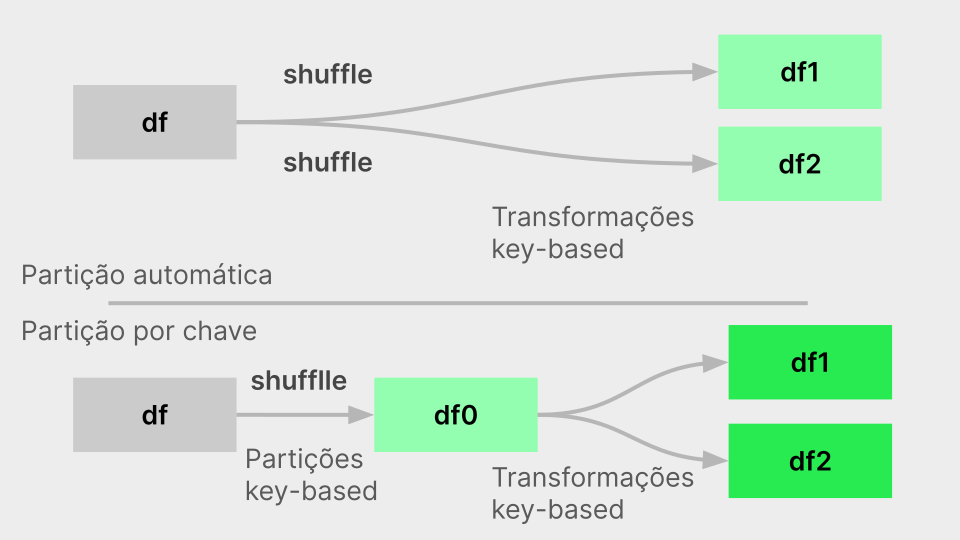

---
Entendendo partições: https://luminousmen.com/post/spark-partitions \
Entendendo partições2: https://techmagie.wordpress.com/2015/12/19/understanding-spark-partitioning/ \
Tunning: https://luminousmen.com/post/spark-tips-partition-tuning

In [12]:
print(f'Particionamento padrão: {df.rdd.getNumPartitions()}')

# nomes mais comuns
df_g = (df.select("nome", "qtde_nascimentos_ate_2010")
  .groupby("nome")
  .agg( sum("qtde_nascimentos_ate_2010")
        .alias("qtde_nascimentos_ate_2010"))
  .sort(col("qtde_nascimentos_ate_2010").desc())
       )

print(f'Particionamento depois do agrupamento: {df_g.rdd.getNumPartitions()}')
df_g.limit(5).toPandas()

Particionamento padrão: 1
Particionamento depois do agrupamento: 170


,nome,qtde_nascimentos_ate_2010
0,Maria,385816
1,Jose,163729
2,Ana,99245
3,Antonio,94619
4,Francisco,93829


Analisando o ultimo stage do job que faz o agrupamento, podemos ver as diversas tasks, uma para cada partição, representadas pelas barras de eventos
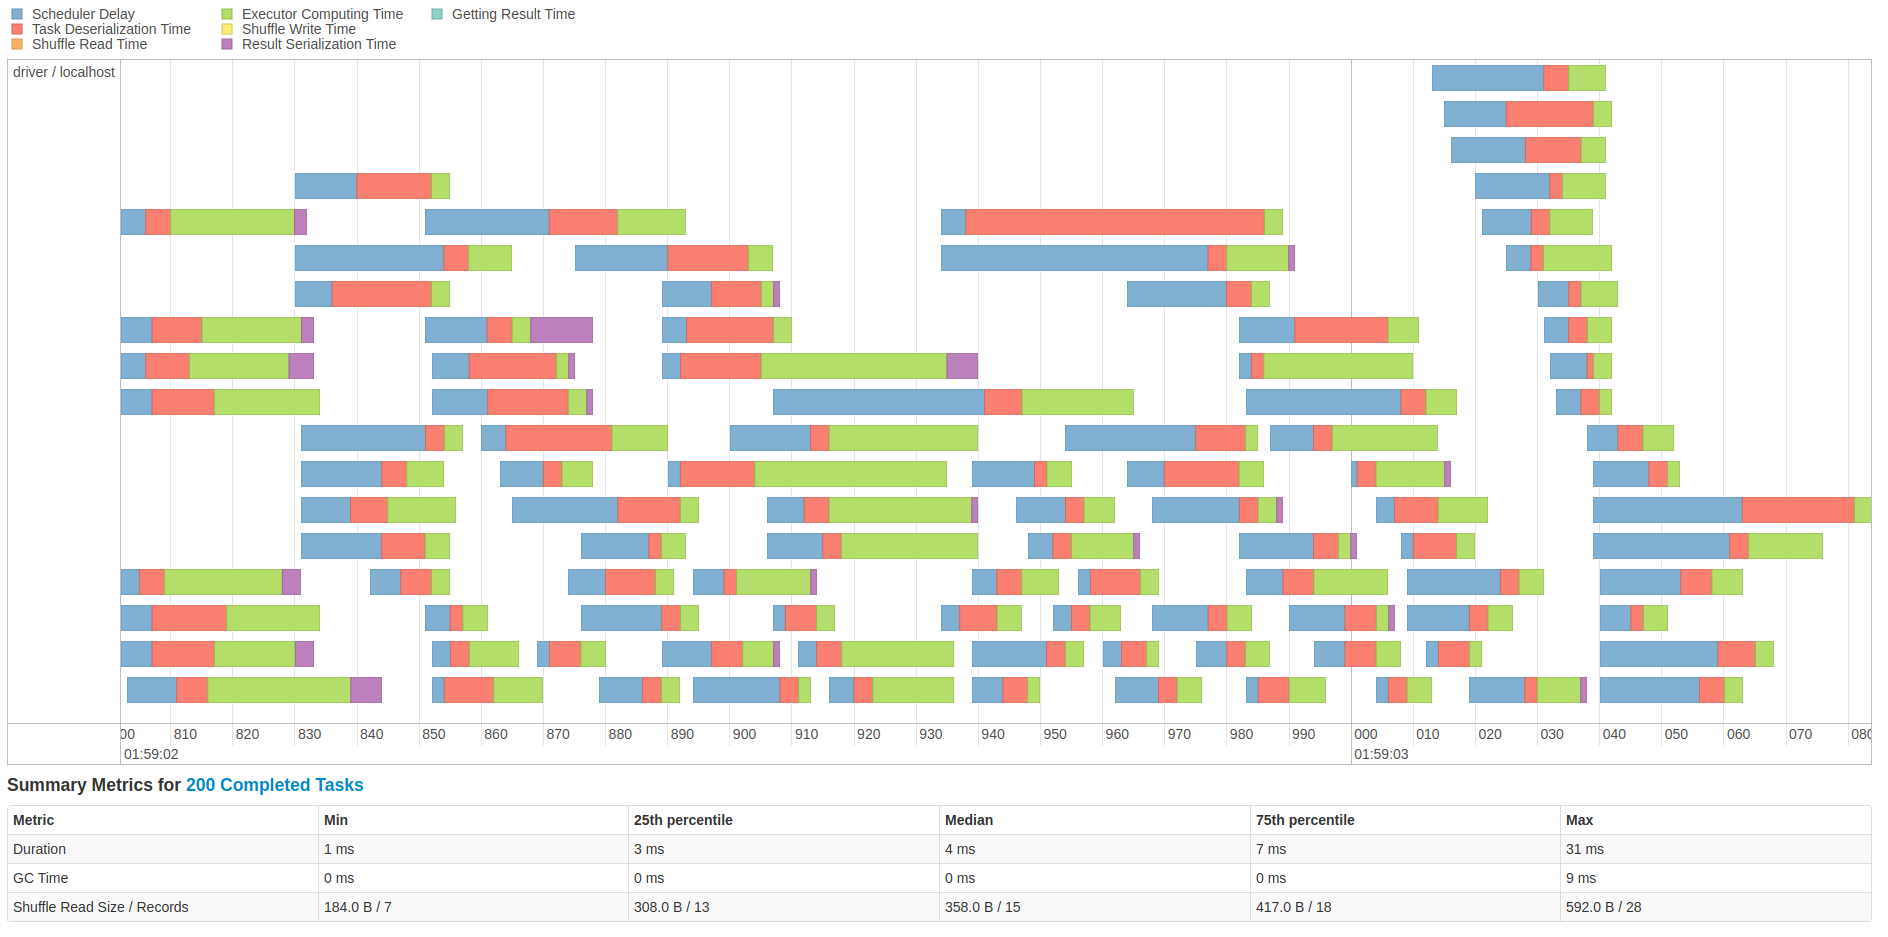

Olhando esse event timeline a gente consegue analisar, por exemplo, se as tasks estão "esperando" para serem inicializas (_Scheduler Delay_ em azul), indicando que um aumento no número de nós poderia reduzir tempo de execução dessa task

In [13]:
# Exemplo com muitas partições
repartition_n = df.repartition(400)

(repartition_n.select("nome", "qtde_nascimentos_ate_2010")
  .groupby("nome")
  .agg( sum("qtde_nascimentos_ate_2010")
        .alias("qtde_nascimentos_ate_2010"))
  .sort(col("qtde_nascimentos_ate_2010").desc())
  .limit(5).toPandas())


,nome,qtde_nascimentos_ate_2010
0,Maria,385816
1,Jose,163729
2,Ana,99245
3,Antonio,94619
4,Francisco,93829


Com um número muito grande de partições, o timeline do stage mostra muitas operações de shuffle

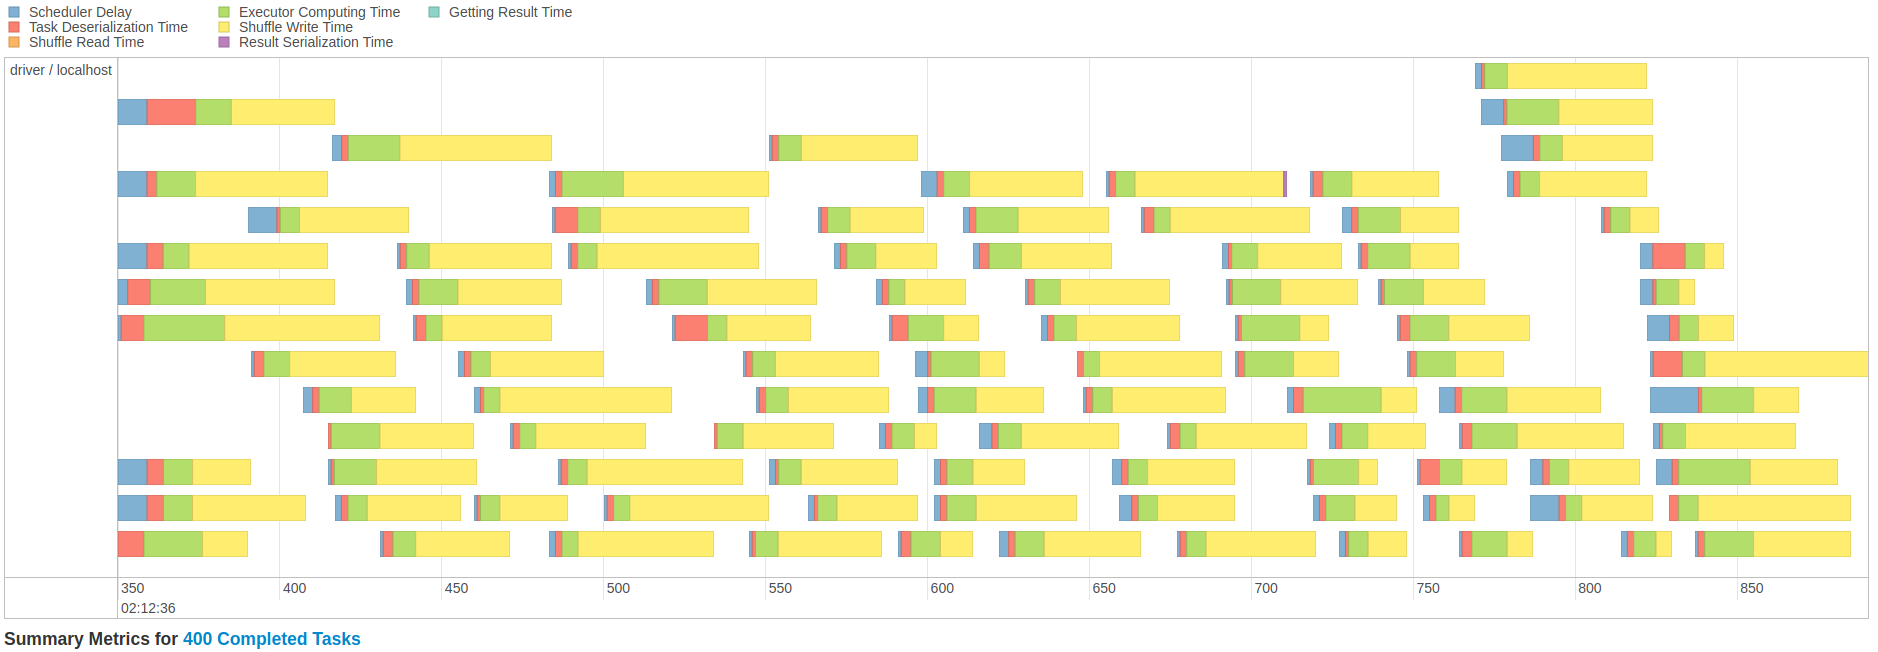

Comparando o tempo do Jobs:
Job 14 (sem repartition manual) =  1s \
Job 17 (com repartition de 400) = 5s

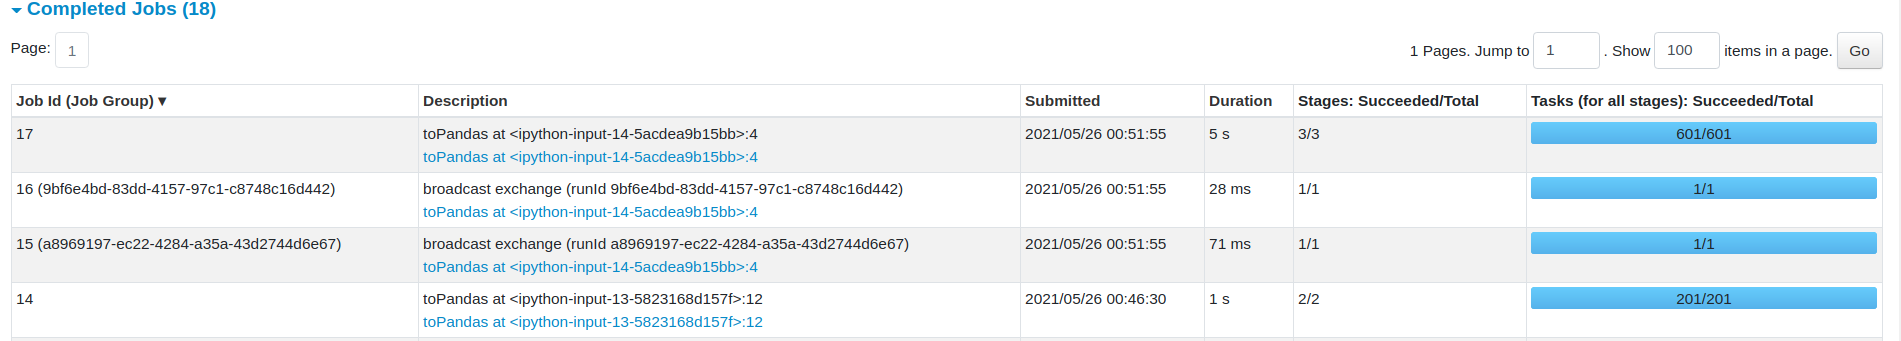

## Cache / Persist

Quando uma ação termina, todos RDDs usados nas transformações são descartados da memória dos workers. Então, quando um dataframe é utilizado várias vezes, caching/persist pode ser beneficial. Assim o lineage desse dataframe não vai ser proocessados repetidamente.

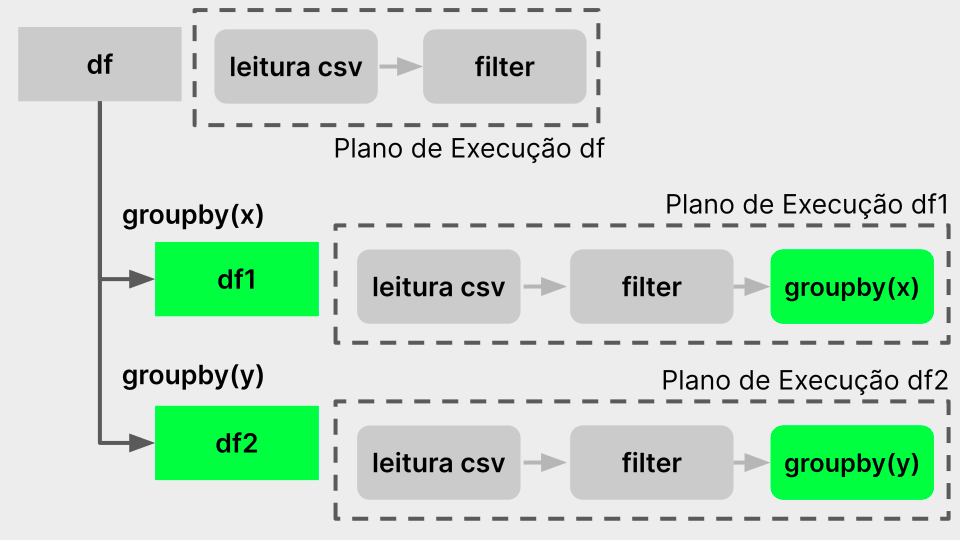

Na prática, o dataset fica em memória (ou também em disco) em todos os workers, cada nó persistindo sua partição e reutilizando em ações aplicadas naquele dataset.

> **Cache** é equivalente ao método **persist**, com valor MEMORY_AND_DISK como localização.

Caching e persist salvam o data lineage, sendo útil caso seja necessário reconstruir os dados da base, caso algum nó do cluster caia (diferente do checkpoint, por exemplo)
 
Exemplo de count em dado com diferentes métodos de cache (fonte: https://towardsdatascience.com/apache-spark-caching-603154173c48):
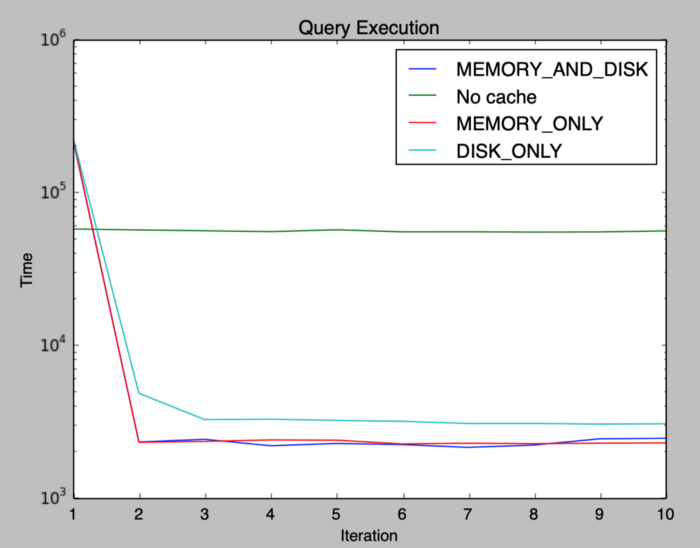

----
Refrência: https://luminousmen.com/post/explaining-the-mechanics-of-spark-caching \
Explicação e melhores práticas: https://towardsdatascience.com/best-practices-for-caching-in-spark-sql-b22fb0f02d34


In [14]:
df_m = df.groupby("id_municipio").sum()
df_a = df.groupby("ano").sum()

In [15]:
df_m.show()
df_a.show()

+------------+------------------------------+
|id_municipio|sum(qtde_nascimentos_ate_2010)|
+------------+------------------------------+
|     1302108|                           976|
|     1100114|                         22814|
|     1100502|                          1315|
|     1300805|                          9612|
|     1100403|                          3305|
|     1100288|                         23291|
|     1304260|                          2009|
|     1101500|                          1525|
|     1303205|                          2702|
|     1300409|                          5270|
|     1100189|                         12531|
|     1100924|                          1227|
|     1302405|                         16928|
|     1100049|                         41094|
|     1100262|                           345|
|     1101708|                          2203|
|     1200401|                        221042|
|     1301852|                         15026|
|     1100379|                    

Jobs 18-20 e 24-26 são iguais, relativos as transformações para obter `df`
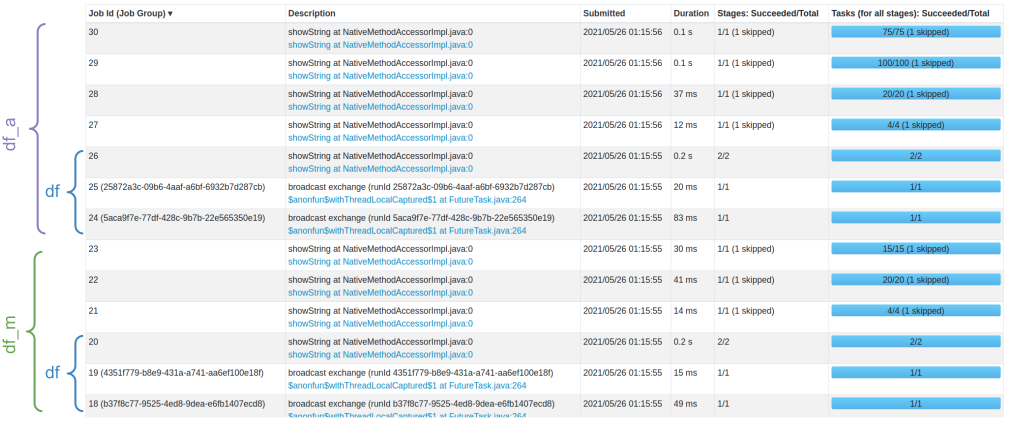

In [21]:
df.cache()
df.count()

16000

Aba Storage no Spark UI agora mostra o dataframe em cache
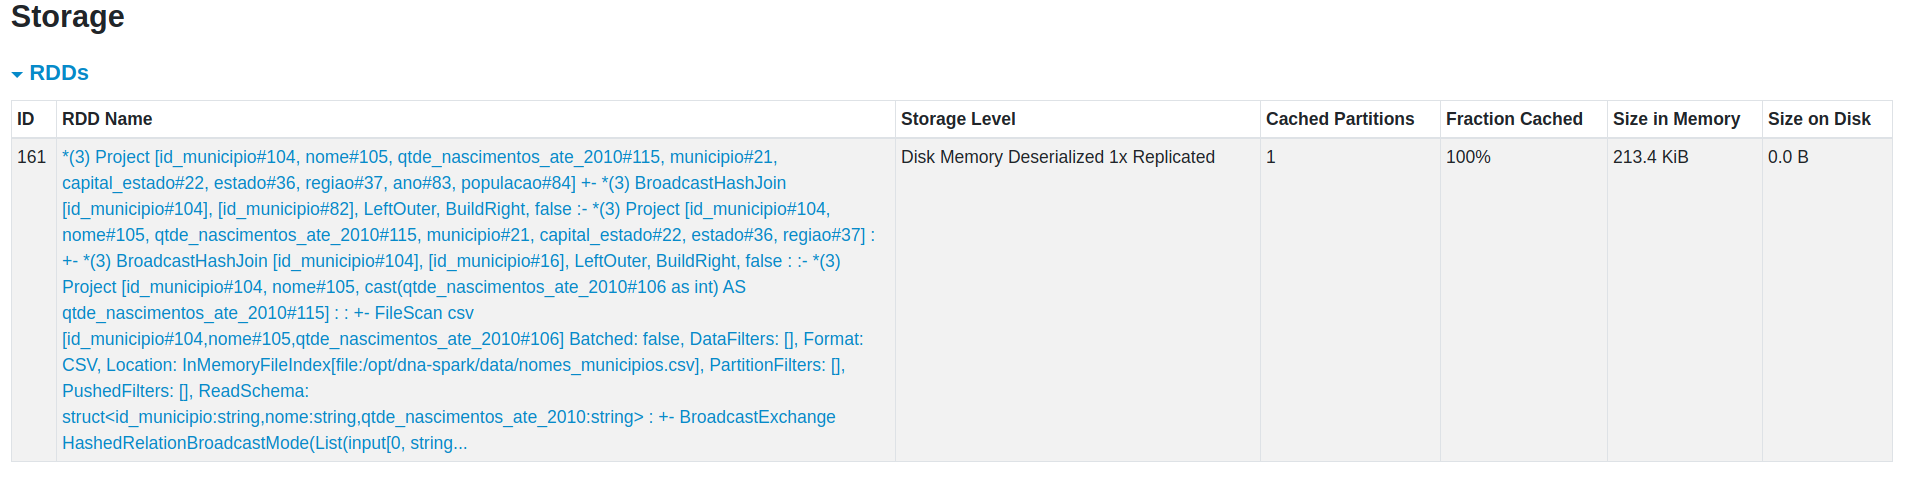

In [22]:
dfc_m = df.groupby("id_municipio").sum()
dfc_m.show()

+------------+------------------------------+
|id_municipio|sum(qtde_nascimentos_ate_2010)|
+------------+------------------------------+
|     1302108|                           976|
|     1100114|                         22814|
|     1100502|                          1315|
|     1300805|                          9612|
|     1100403|                          3305|
|     1100288|                         23291|
|     1304260|                          2009|
|     1101500|                          1525|
|     1303205|                          2702|
|     1300409|                          5270|
|     1100189|                         12531|
|     1100924|                          1227|
|     1302405|                         16928|
|     1100049|                         41094|
|     1100262|                           345|
|     1101708|                          2203|
|     1200401|                        221042|
|     1301852|                         15026|
|     1100379|                    

jobs 34-37 são do agrupamento para obter `dfc_m`
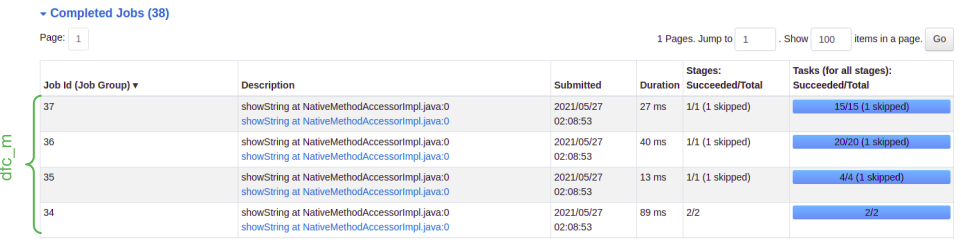

Comparação de tempo entre função lowercase criado em UDF e a utilização da função lowercase do spark:
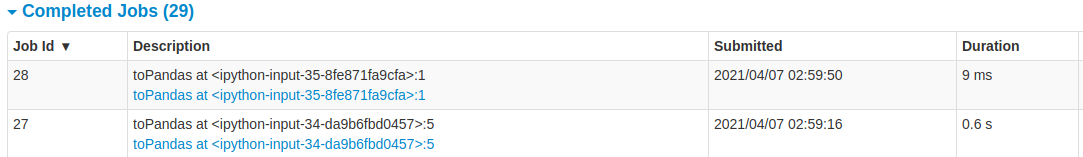

## Spark solucionando casos reais!
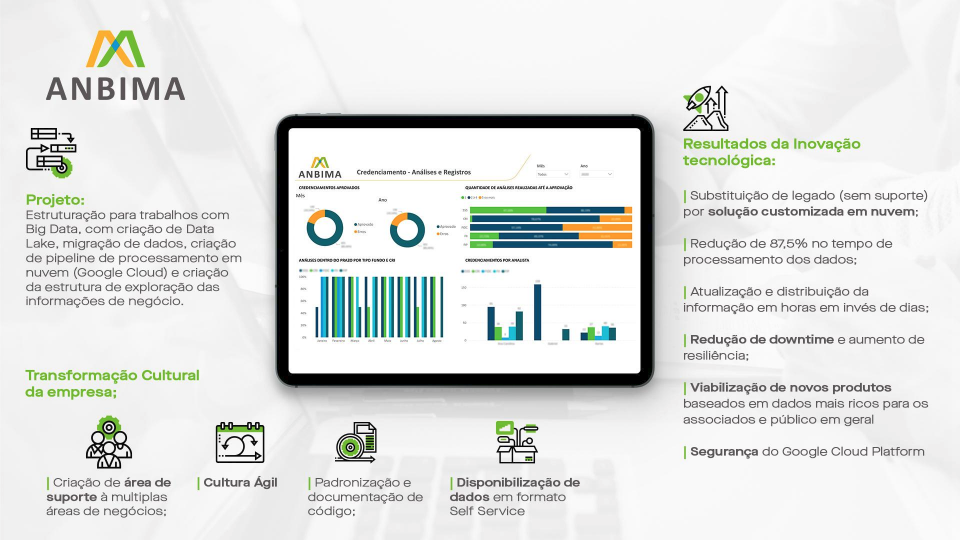

## Referências

- https://luminousmen.com/post/hadoop-yarn-spark
- https://luminousmen.com/post/spark-tips-dataframe-api
- https://sparkbyexamples.com/
- https://spark.apache.org/docs/3.0.0-preview2/web-ui.html
- https://www.youtube.com/watch?v=daXEp4HmS-E&feature=youtu.be
- https://spark.apache.org/docs/latest/sql-performance-tuning.html
- https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html
- https://spark.apache.org/docs/3.0.0-preview/sql-ref-nan-semantics.html
- https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html
- https://www.tutorialdocs.com/article/spark-memory-management.html
- https://blog.scottlogic.com/2018/03/22/apache-spark-performance.html
- https://medium.com/@goyalsaurabh66/spark-basics-rdds-stages-tasks-and-dag-8da0f52f0454
- https://ichi.pro/pt/planos-de-consulta-do-spark-para-leigos-122282881757510
- https://blog.knoldus.com/understanding-sparks-logical-and-physical-plan-in-laymans-term/
- https://medium.com/datalex/sparks-logical-and-physical-plans-when-why-how-and-beyond-8cd1947b605a

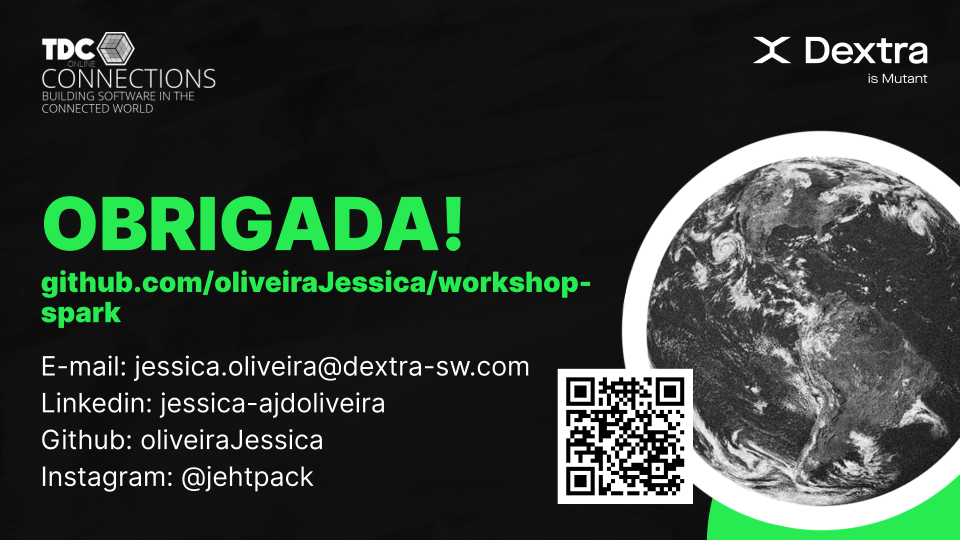